# McCormick Relaxation Arithmetic for Factorable Functions
A convex relaxation $f^{cv}$ of a function $f$ on the convex domain D is a function that is (i) convex on D and (ii) underestimates $f$ on D. Likewise, a concave relaxation $f^{cc}$ of a function $f$ on the convex domain D is a function that is (i) concave on D and (ii) overestimates $f$ on D. McCormick's technique ([McCormick, 1976](https://link.springer.com/article/10.1007/BF01580665)) provides a means for computing pairs of convex/concave relaxations of a multivariate function on interval domains provided that this function is factorable and that the intrinsic univariate functions in its factored form have known convex/concave envelopes or, at least, relaxations.

## Performing McCormick Relaxations in PyMC

Suppose we want to compute a McCormick relaxation of the real-valued function $f(x,y)=x(\exp(x)-y)^2$ for $(x,y)\in [-2,1]\times[-1,2]$, at the point $(x,y)=(0,1)$. 

We start by importing the PyMC library:

In [1]:
import pymc

Then, we proceed by defining the ranges of both variables $x$ and $y$:

In [2]:
xI, yI = pymc.Interval(-2,1), pymc.Interval(-1,2)
xMC, yMC = pymc.McCormick( xI, 0 ), pymc.McCormick( yI, 1 )
#xI, yI = pymc.Interval(0,10), pymc.Interval(0,20)
#xMC, yMC = pymc.McCormick( xI, 5 ), pymc.McCormick( yI, 10 )
print(xMC)
print(yMC)

[ -2.00000e+00 :  1.00000e+00 ] [  0.00000e+00 :  0.00000e+00 ]
[ -1.00000e+00 :  2.00000e+00 ] [  1.00000e+00 :  1.00000e+00 ]


Briefly, the first line defines the interval ranges `xI` and `yI` for the variables $x\in[-2,1]$ and $y\in[-1,2]$. The second line then defines the McCormick relaxations `xMC` and `yMC` of type `pymc.McCormick`, with ranges `xI` and `yI`, repectively, and current values of $0$ and $1$.

### Using Operator Overloading

With operator overloading, we can simply compute a McCormick relaxation of $f(x,y)=x(\exp(x)−y)^2$ on $[−2,1]\times[−1,2]$ at $(0,1)$ as:

In [3]:
zMC = xMC*(pymc.exp(xMC)-yMC)**2
#zMC = pymc.exp(pymc.sin(xMC)+pymc.sin(yMC)*pymc.cos(yMC))
print( "McCormick relaxation at (", xMC.cv, ",", yMC.cv, "):", zMC )

McCormick relaxation at ( 0.0 , 1.0 ): [ -2.76512e+01 :  1.38256e+01 ] [ -1.38256e+01 :  8.52245e+00 ]


Here, the first pair of bounds correspond to the supporting interval bounds, as obtained with `pymc.Interval`, and which are valid over the entire domain $[−2,1]\times[−1,2]$. The second pair of bounds are the values of the convex and concave relaxations at the selected point $(0,1)$. 

In order to describe the convex and concave relaxations on the entire range $[−2,1]×[−1,2]$, we need to repeat the computations at different points. The current point can be set/modified by using the method `c`, for instance at $(-1,0)$:

In [4]:
xMC.c( -1 )
yMC.c( 0 )
print(xMC)
print(yMC)
zMC = xMC*(pymc.exp(xMC)-yMC)**2
print( "McCormick relaxation at (", xMC.cv, ",", yMC.cv, "):", zMC )

[ -2.00000e+00 :  1.00000e+00 ] [ -1.00000e+00 : -1.00000e+00 ]
[ -1.00000e+00 :  2.00000e+00 ] [  0.00000e+00 :  0.00000e+00 ]
McCormick relaxation at ( -1.0 , 0.0 ): [ -2.76512e+01 :  1.38256e+01 ] [ -1.75603e+01 :  8.78014e+00 ]


The values of the McCormick convex and concave relaxations of $f(x,y)$ at the current, as well as lower and upper bounds on the range of $f(x,y)$ over the current domain can be retrieved using the members `cv`, `cc`, `l` and `u`, respectively:

In [5]:
print("convex/concave relaxations:", zMC.cv, zMC.cc)
print("lower/upper bounds:",zMC.l, zMC.u)

convex/concave relaxations: -17.560280068546856 8.780140034273428
lower/upper bounds: -27.651239511697487 13.825619755848743


Computing a subgradient of a McCormick relaxation requires initializing subgradients for all independent variables using the method 'sub', prior to evaluating the function in McCormick arithmetic. Continuing the previous example, initializing subgradients for the variables $x$ and $y$ as components $0$ and $1$, respectively, is done as follows:

In [6]:
xMC.sub( 2, 0 )
yMC.sub( 2, 1 );

Notice that indices start at 0 by convention.
 
 Similar to above, the McCormick convex and concave relaxations of $f(x,y)$ at $(-1,0)$ along with subgradients of these relaxations are computed as:

In [7]:
zMC = xMC*(pymc.exp(xMC)-yMC)**2
print( "McCormick relaxation at (", xMC.cv, ",", yMC.cv, "):", zMC )

McCormick relaxation at ( -1.0 , 0.0 ): [ -2.76512e+01 :  1.38256e+01 ] [ -1.75603e+01 :  8.78014e+00 ] [ (-3.19186e+00, 3.70723e+00) : ( 1.59593e+00,-1.85362e+00) ]


The additional information displayed corresponds to a subgradient of the convex underestimator of $f$ at $(-1,0)$ and a subgradient of the concave overestimator of $f$ at $(-1,0)$, respectively.

In turn, these subgradients can be used to construct affine relaxations on the current range, or passed to a bundle solver to locate the actual minimum or maximum of the McCormick relaxations. 

The subgradients of the McCormick relaxations of $f$ at the current point can be retrieved as:

In [8]:
print(zMC.cvsub)
print(zMC.ccsub)

[-3.1918626098796556, 3.7072342233913163]
[1.5959313049398278, -1.8536171116956581]


Directional subgradients can be propagated too. In the case that subgradients are to computed along the direction (1,-1) for both the convex and concave relaxations, we define:

In [9]:
xMC.sub( [1], [1] )
yMC.sub( [-1], [-1] )
zMC = xMC*(pymc.exp(xMC)-yMC)**2
print( "McCormick relaxation at (", xMC.cv, ",", yMC.cv, ") and subgradients in direction (", xMC.cvsub[0], ",", yMC.ccsub[0], "):", zMC )

McCormick relaxation at ( -1.0 , 0.0 ) and subgradients in direction ( 1.0 , -1.0 ): [ -2.76512e+01 :  1.38256e+01 ] [ -1.75603e+01 :  8.78014e+00 ] [ (-6.89910e+00) : ( 3.44955e+00) ]


### Using Expression Trees

We start by constructing a DAG of $f$ (cf. [Other notebook](./ffunc.ipynb)):

In [10]:
DAG = pymc.FFGraph()
X, Y = pymc.FFVar(DAG,"x"), pymc.FFVar(DAG,"y")
F = X*(pymc.exp(X)-Y)**2
F.set("f")
DAG.output(DAG.subgraph([F]))


OPERATIONS IN SUBGRAPH:
  x	<-  VARIABLE
  Z0	<<  EXP( x )	
  y	<<  VARIABLE
  Z1	<<  Z0 - y	
  Z2	<<  SQR( Z1 )	
  f	<<  x x Z2	
DEPENDENTS IN SUBGRAPH:
  0:  f
WORK ARRAY SIZE: 6


Then, we evaluate the DAG using McCormick arithmetic:

In [11]:
[fMC] = DAG.eval([F], [X,Y], [xMC,yMC])
print(fMC)

[ -2.76512e+01 :  1.38256e+01 ] [ -1.75603e+01 :  8.78014e+00 ] [ (-6.89910e+00) : ( 3.44955e+00) ]


### Visualization

A 3d plot of the function $f$ that shows both convex and concave relaxations over the domain $[-2,1]\imtes[-1,2]$ is constructed below. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

xref, yref = 0, 1  # reference point for affine estimators
xrefMC, yrefMC = pymc.McCormick( xI, xref ).sub(2,0), pymc.McCormick( yI, yref ).sub(2,1)
zrefMC = xrefMC*(pymc.exp(xrefMC)-yrefMC)**2
#zrefMC = pymc.exp(pymc.sin(xrefMC)+pymc.sin(yrefMC)*pymc.cos(yrefMC))

N = 64
matx = np.outer(np.linspace(xI.l, xI.u, N), np.ones(N))
maty = np.outer(np.ones(N), np.linspace(yI.l, yI.u, N))
matf = matx*(np.exp(matx)-maty)**2
#matf = np.exp(np.sin(matx)+np.sin(maty)*np.cos(maty))
#print( matf )

matfcv = np.ndarray(shape=(N,N))
matfcc = np.ndarray(shape=(N,N))
matflaff = np.ndarray(shape=(N,N))
matfuaff = np.ndarray(shape=(N,N))

for i,j in product(range(N), range(N)):
  xMC.c( matx[i,j] ).sub(2,0)
  yMC.c( maty[i,j] ).sub(2,1)
  zMC = xMC*(pymc.exp(xMC)-yMC)**2
  #zMC = pymc.exp(pymc.sin(xMC)+pymc.sin(yMC)*pymc.cos(yMC))
  #print( xMC, yMC, zMC )
  matfcv[i,j] = zMC.cv
  matfcc[i,j] = zMC.cc
  matflaff[i,j] = zrefMC.laff( [matx[i,j],maty[i,j]], [xref,yref] )
  matfuaff[i,j] = zrefMC.uaff( [matx[i,j],maty[i,j]], [xref,yref] )
#print( matfcv )
#print( matfcc )
#print( matflaff )
#print( matfuaff )

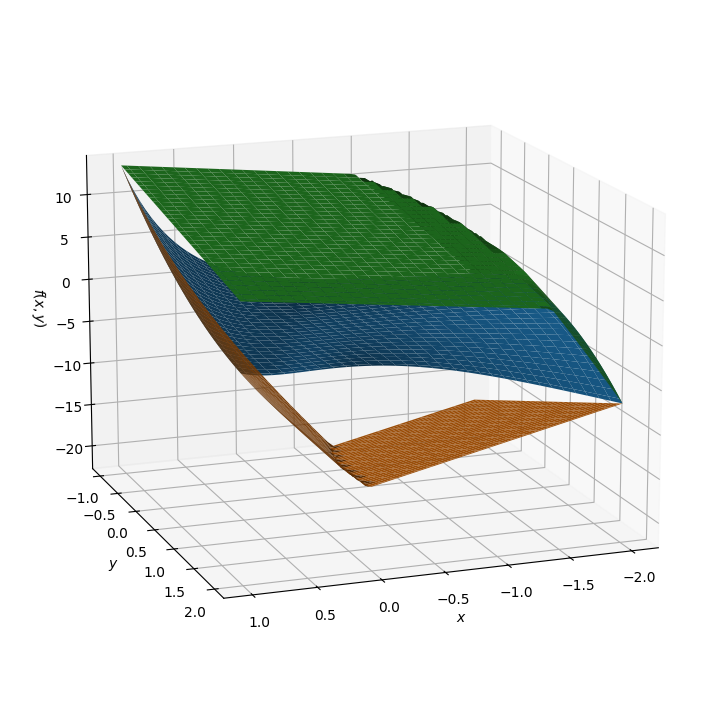

In [13]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$')

ax.plot_surface(matx, maty, matf)
ax.plot_surface(matx, maty, matfcv)
ax.plot_surface(matx, maty, matfcc)
ax.view_init(elev=15, azim=70)

plt.show()

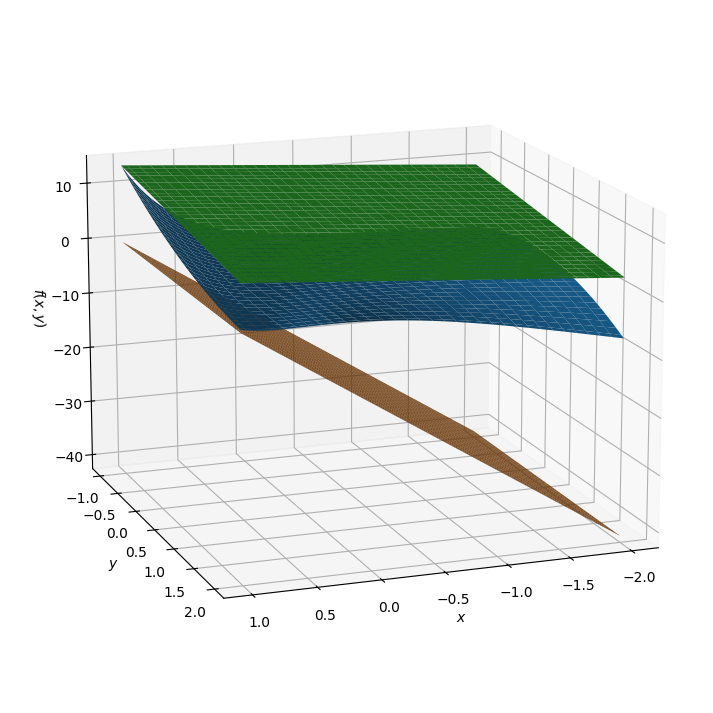

In [14]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$')

ax.plot_surface(matx, maty, matf)
ax.plot_surface(matx, maty, matflaff)
ax.plot_surface(matx, maty, matfuaff)
ax.view_init(elev=15, azim=70)

plt.show()